# Network Backboning with Latent Dynamics Inference

Author: Thurston Sexton

Date: 2020.06.23

In [3]:
from functools import partial
import numpy as onp
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline

import jax.numpy as np
from jax.random import PRNGKey
from jax import jit, grad, lax, random, vmap
from jax.ops import index_update, index, index_add
from jax.nn import one_hot
from jax.experimental import ode

import numpyro as ny
import numpyro.distributions as dist

# testing other numpyro goodies
from numpyro.util import fori_loop
from numpyro.infer.autoguide import AutoBNAFNormal
from numpyro.contrib.autoguide import AutoContinuousELBO
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer import  ELBO, SVI, NUTS
from numpyro.infer.util import initialize_model, potential_energy, init_to_value

## Synthesize Data

### Underlying Network Structure

In [4]:
def squareform(edgelist):
    """edgelist to adj. matrix"""
    e = edgelist.shape[0]
    n = ((1 + np.sqrt(1 + 8*e))/2.).astype('int32')
    empty = np.zeros((n,n))
    half = index_add(empty, index[np.triu_indices(n,1)], edgelist)
    full = half+half.T
    return full

def edgelist(squareform):
    n = squareform.shape[0]
    idx = index[np.triu_indices(n,1)]
    return squareform[idx]

def synthesize_network(
    n_nodes,
    *gen_func_args,
    gen_func=nx.connected_watts_strogatz_graph,
):
    n_edges = n_nodes*(n_nodes-1)//2
    g = gen_func(n_nodes, *gen_func_args)
    e = onp.random.beta(5,1,size=(n_edges,))
    p = onp.array(
        squareform(e)*nx.to_numpy_array(g)
#         0.3*nx.to_numpy_array(g)
    )

    for src,trg in g.edges:
        g.edges[src,trg]['weight'] = p[src,trg]
    return g, edgelist(p), p

In [5]:
n_nodes = 10
g, e, p = synthesize_network(n_nodes, 3, 0.33)

Text(0.5, 1.0, '"True" transmission matrix')

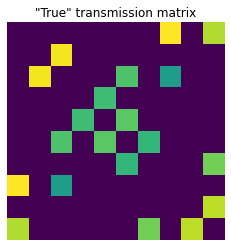

In [6]:
def nodeplot(u):
    plt.figure()
    plt.imshow(u.reshape(-1,1).T, vmin=0, vmax=1)
    plt.axis('off')

def adjplot(p):
    plt.figure()
    plt.imshow(p, vmin=0, vmax=1)
    plt.axis('off')
adjplot(p)
plt.title('"True" transmission matrix')

### Dynamic Spreading/Diffusion Process

In [9]:
# Sources
n_obs = 20
sources = onp.random.choice(n_nodes, size=(n_obs,1))
init = onp.zeros((n_obs, n_nodes))
onp.put_along_axis(init,sources, 1, 1)

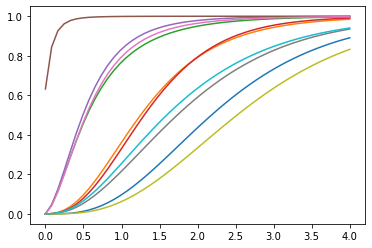

In [10]:
# Test New way to diffuse
# http://www.michelecoscia.com/wp-content/uploads/2020/03/FULL-CosciaM1099.pdf
# https://arxiv.org/pdf/1603.06790.pdf

@jit
def laplacian(p):
    return np.diag(p.sum(axis=0))-p

@jit 
def df_dt(f, t, L, k):
    return -k*np.matmul(L,f[...,None]).squeeze(-1)
#     return -k*L.dot(f)


# inspiration from survival analysis
def hazard_to_cdf(h):
    cum_hazard = np.cumsum(h, axis=0)
    return 1 - np.exp(-cum_hazard)

L = laplacian(p)
t = np.linspace(0,4,50)
c = hazard_to_cdf(
    ode.odeint(df_dt, 
               init.astype('float32'),
               t, L, .9
    ))
plt.plot(t, c[:,3,:])

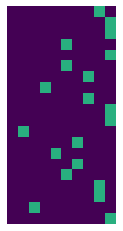

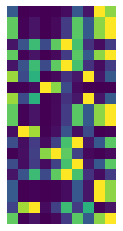

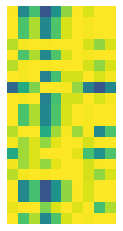

In [45]:
adjplot(c[0,:,:])
adjplot(c[10,:,:])
adjplot(c[100,:,:])

In [12]:
# OLD WAY
def a_or_b(a,b):
    """probability of a or b is not(not a & not b)"""
    return 1 - onp.multiply(1-a, 1-b)


def spread(p,u,t, T=5):
    """modified https://arxiv.org/pdf/1511.01062.pdf
    p: transmission probability matrix
    u: vector of node states (infection)
    T: num. iterations to observe final states at
    """
    # u_add = p@u  # pure heat kernel grows uncontrollably
    # u_p = onp.clip(u + u_add, 0,1)  # clip from paper above
    # u_p = onp.clip(a_or_b(u, u_add), 0,1)  # convolve and clip

    
    u_add = onp.tanh(p@u)   # tanh approx probability of transmission
    u_p = a_or_b(u, u_add)  # probability convolution (w/past)
    
    if t==T:  # end
        return u_p
    else:  # recurse
        return spread(p,u_p, t+1, T)

Text(0.5, 1.0, 'T=2 realize infection')

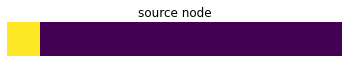

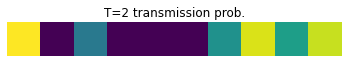

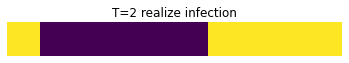

In [13]:
# Example
u = onp.array([1]+(n_nodes-1)*[0])
u_p = spread(p,u,0, T=1)
# real = onp.random.binomial(1, u_p)
real = u_p>=0.5

nodeplot(u)  
plt.title('source node')
nodeplot(u_p)  
plt.title('T=2 transmission prob.')
nodeplot(real)
plt.title('T=2 realize infection')

### Synthetic Observations of Repeated Diffusion

In [14]:


# realize = lambda x, T: onp.random.binomial(1, spread(p, x, 0, T))
realize = lambda x, T: (spread(p,x,0,T) >= 0.8).astype('int32')
# use this
infections = np.stack([realize(i, 1) for i in init])

# to compare 
late = np.stack([realize(i, 1) for i in infections])

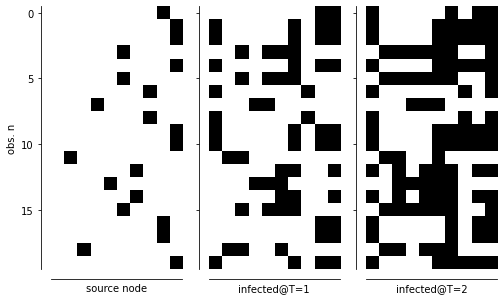

In [15]:
f, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8,10))
ax[0].spy(init)
ax[0].set_xlabel('source node')
ax[0].set_ylabel('obs. n')
# plt.axis('off')


ax[1].spy(infections)
ax[1].set_xlabel('infected@T=1')



ax[2].spy(late)
ax[2].set_xlabel('infected@T=2')
ax[0].set_xticks([])

sns.despine(f, offset=10)
plt.show()

Easier to see on the network.

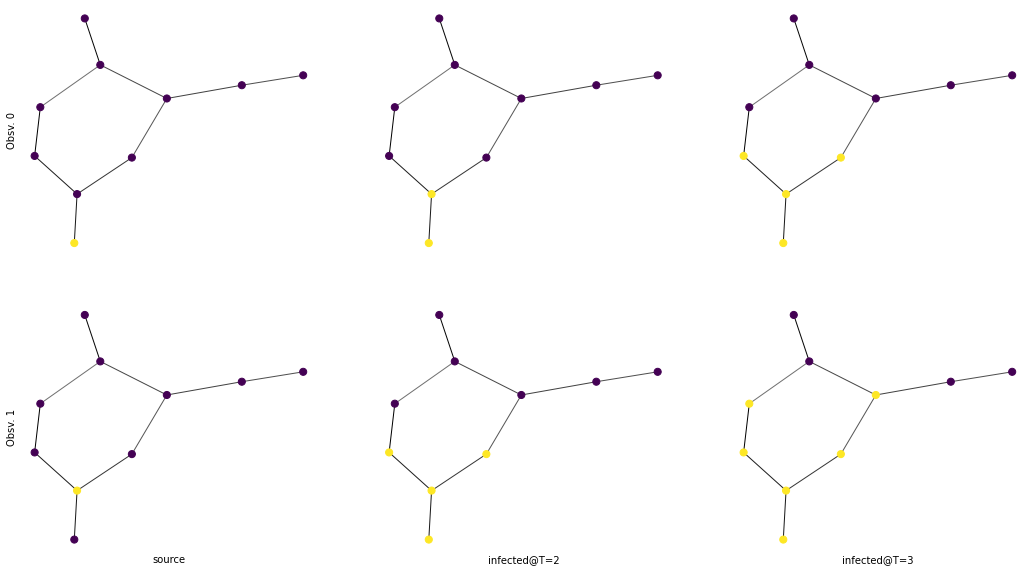

In [16]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex=True, sharey=True)
pos = nx.layout.fruchterman_reingold_layout(g)
get_weights = lambda g: [v for k,v in nx.get_edge_attributes(g,'weight').items()]

nx_draw_opts = dict(
#     edge_color=weights,
#     edge_color='grey',
    pos=pos, 
    with_labels=False, 
    node_size=50,
    edge_cmap=cm.binary,
    edge_vmin=0,edge_vmax=1,
)
for n,axis in enumerate(ax):
#     infected = infect_on_network(a)(x0, T=(n+1)*5)
    nx.draw_networkx(g, ax=axis[0], 
                     node_color=init[n], node_cmap=cm.Paired,
                     edge_color=get_weights(g),
                    **nx_draw_opts)
    nx.draw_networkx(g, ax=axis[1], 
                     node_color=infections[n], node_cmap=cm.Paired,
                     edge_color=get_weights(g),
                    **nx_draw_opts)
    nx.draw_networkx(g, ax=axis[2], 
                     node_color=late[n], node_cmap=cm.Paired,
                     edge_color=get_weights(g),
                    **nx_draw_opts)
    axis[0].set_ylabel(f'Obsv. {n}')

for n,axis in enumerate(ax.flatten()):
    sns.despine(left=True, bottom=True)
ax[1][0].set_xlabel('source')
ax[1][1].set_xlabel('infected@T=2')
ax[1][2].set_xlabel('infected@T=3')
plt.show()

## Backboning: Recover Structure

### Naive Way (cosine similarity+threshold)

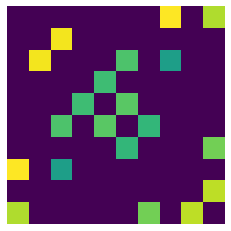

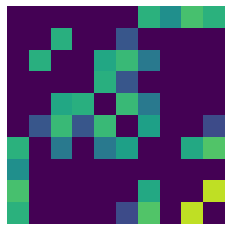

In [17]:
def cosine_sim(X):
    norm = X/onp.sqrt((X**2).sum(axis=0))
#     cos = X.T.dot(X)/(onp.sqrt((X**2).sum()))
    cos = norm.T.dot(norm)
    return cos - onp.diag(onp.diag(cos))  # valid adjacency

# compare
adjplot(p)
adjplot(cosine_sim(infections))


In [18]:
# jax version of `spread`
def diffuse_one_step(p, u):
    u_add = lax.tanh(np.matmul(p,u[...,None]).squeeze(-1))  # from neighbors
    u_p = 1-(1-u)*(1-u_add)  # combine with self
    return u_p, u_add

# Should @jit? see: https://github.com/google/jax/issues/2251#issuecomment-587742824
def diffuse(p, T, u_init):
    """
    modified https://arxiv.org/pdf/1511.01062.pdf
    p: transmission probability matrix
    u_init: initial infection node states
    T: num. iterations to observe at
    """
    def scan_fn(u, t):
        return diffuse_one_step(p, u)
    
    u_end, _ = lax.scan(scan_fn, u_init, np.arange(T))
    return np.clip(u_end, a_max=1.-1e-6)

# def batched_diffuse(p, T, u_obs):
#     """ batched over rows of u observations (`vmap`)
#     """
#     return vmap(partial(diffuse, p, T))(u_obs)

In [42]:
def structure_recovery(infections=None):
    n_cascades, n_nodes  = infections.shape
    n_edges = n_nodes*(n_nodes-1)//2 # complete graph
        
    # node initial infection, relative probability
    ϕ = ny.sample("ϕ", dist.Dirichlet(np.ones(n_nodes)))
    
    # beta hyperpriors
    u = ny.sample("u", dist.Uniform(0, 1).expand([n_edges]).to_event(1))
    v = ny.sample("v", dist.Gamma(1, 20).expand([n_edges]).to_event(1))
#     Λ = ny.sample("Λ", dist.Beta(u*v, (1-u)*v).to_event(1))
    
    # Separate out sparsity structure from interaction strength
    # http://proceedings.mlr.press/v32/linderman14.pdf
    ρ = ny.sample('ρ', dist.Beta(u*v, (1-u)*v).to_event(1))  # transmission
    A = ny.sample('A', dist.Bernoulli(probs=ρ).to_event(1))  # sparse adjacency
    s_ij = squareform(ρ*A)  # adjacency matrix to recover via inference
    
    adjplot(s_ij) # FOR TESTING
    
    with ny.plate("n_cascades", n_cascades, dim=-1):
        # infer infection source node
        x0 = ny.sample("x0", dist.Categorical(probs=ϕ))  # hierarchical model
#         x0 = ny.sample("x0", dist.Categorical(probs=np.ones(n_nodes)/n_nodes)) # flat prior
        
        # encode as one-hot vectors
        src = one_hot(x0, n_nodes)  
        
        # simulate ode and realize
        p_infectious = diffuse(s_ij, 1, src)
        real = dist.Bernoulli(probs=p_infectious).to_event(1)
        return ny.sample("obs", real, obs=infections)

NotImplementedError: 

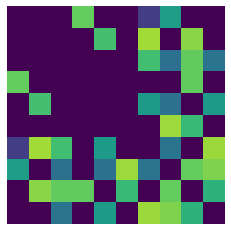

In [43]:
# ny.set_host_device_count(4)
kernel = ny.infer.NUTS(structure_recovery, target_accept_prob=.8,
#                        init_strategy=init_to_value(values={
#                            'Λ': edgelist(cosine_sim(infections))
#                        })
                      )
mcmc = ny.infer.MCMC(kernel, num_warmup=1500, num_samples=3000)
mcmc.run(PRNGKey(0), infections=infections)
mcmc.print_summary()
samples = mcmc.get_samples()

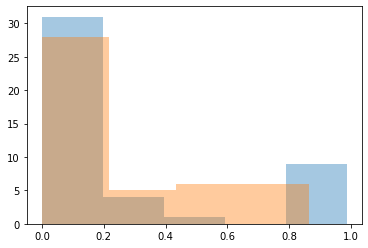

In [307]:
sns.distplot(samples["Λ"].mean(axis=0), norm_hist=False, kde=False)
sns.distplot(edgelist(cosine_sim(infections)), norm_hist=False, kde=False)

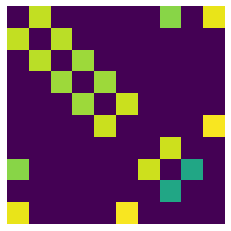

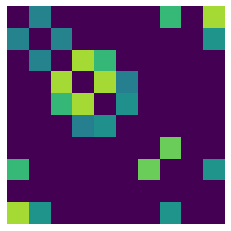

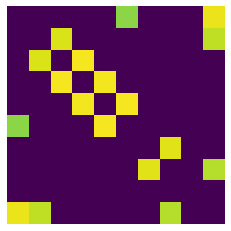

In [311]:
pred = squareform(samples["Λ"].mean(axis=0))
pred = pred*(pred>.6)
cos = cosine_sim(infections)*(cosine_sim(infections)>.4)
adjplot(p)
adjplot(cos)
adjplot(pred)

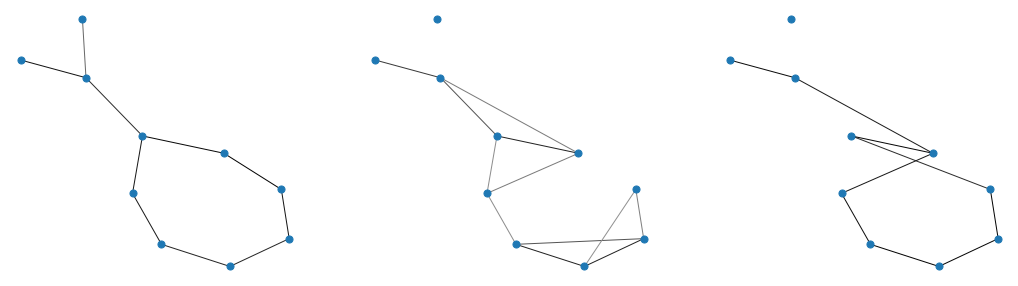

In [312]:
f,axis = plt.subplots(ncols=3, figsize=(18,5), sharex=True, sharey=True)

#     infected = infect_on_network(a)(x0, T=(n+1)*5)
nx.draw_networkx(g, ax=axis[0],
                 edge_color=get_weights(g),
                **nx_draw_opts)
nx.draw_networkx(nx.from_numpy_array(cos), ax=axis[1],
                 edge_color=get_weights(nx.from_numpy_array(cos)),
                **nx_draw_opts)
nx.draw_networkx(nx.from_numpy_array(pred), ax=axis[2],
                 edge_color=get_weights(nx.from_numpy_array(pred)),
                **nx_draw_opts)
# axis[0].set_ylabel(f'Obsv. {n}')
for n,axis in enumerate(ax.flatten()):
    sns.despine(left=True, bottom=True)
plt.show()
# nx.draw_networkx(, **nx_draw_opts)

### Try svi

In [224]:
# Construct an SVI object so we can do variational inference on our
    # model/guide pair.
adam = ny.optim.Adam(1e-3)
guide = AutoBNAFNormal(structure_recovery)
svi = SVI(structure_recovery, guide, adam, ELBO(num_particles=10))
svi_state = svi.init(PRNGKey(0), infections)

# Training loop
def body_fn(i, val):
    svi_state, loss = svi.update(val, infections)
    return svi_state

svi_state = fori_loop(0, 1001, body_fn, svi_state)

# Report the final values of the variational parameters
# in the guide after training.
params = svi.get_params(svi_state)
for name, value in params.items():
    print("{} = {}".format(name, value))


auto_arn__0$params = [(DeviceArray([[-0.2776143 ,  0.7838745 , -0.72208536, ...,  0.09527027,
               0.0462908 , -0.02423801],
             [ 0.        ,  0.        ,  0.        , ...,  0.02085378,
               0.00740156,  0.03427128],
             [ 0.        ,  0.        ,  0.        , ...,  0.02865113,
               0.06422674,  0.01073873],
             ...,
             [ 0.        ,  0.        ,  0.        , ..., -0.05262911,
               0.03118366,  0.02830646],
             [ 0.        ,  0.        ,  0.        , ...,  0.05055162,
              -0.00801879, -0.07990434],
             [ 0.        ,  0.        ,  0.        , ...,  0.4319476 ,
               0.5235744 ,  0.4412799 ]], dtype=float32), DeviceArray([-1.5874271 , -0.7979889 , -1.2204467 , ..., -0.3488366 ,
             -0.88036424, -0.41266754], dtype=float32), DeviceArray([ 0.14770952, -0.12870742, -0.15488178, ...,  0.00180213,
             -0.01855661, -0.00267007], dtype=float32)), (), (DeviceArray(

### try NeuTra

In [196]:
guide = AutoBNAFNormal(structure_recovery)
svi = SVI(structure_recovery, guide, ny.optim.Adam(1.0e-3), ELBO())
svi_state = svi.init(random.PRNGKey(1),infections)
last_state, losses = lax.scan(lambda state, i: svi.update(state, infections), svi_state, np.zeros(2000))
params = svi.get_params(last_state)

In [199]:
print("\nStart NeuTra HMC...")
neutra = NeuTraReparam(guide, params)
neutra_model = neutra.reparam(structure_recovery)
nuts_kernel = NUTS(neutra_model)
mcmc = ny.infer.MCMC(nuts_kernel, num_warmup=1500, num_samples=3000)
mcmc.run(random.PRNGKey(3), infections=infections)
mcmc.print_summary()
zs = mcmc.get_samples()
print("Transform samples into unwarped space...")
samples = neutra.transform_sample(zs)


Start NeuTra HMC...


AssertionError: all sites must have unique names